<a href="https://colab.research.google.com/github/idjoopal/NLP_tensorflow2.0/blob/main/%EC%8B%A4%EC%8A%B5_1_CNN_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 1. CNN을 이용한 😀감정분석😑 모델 학습하기

<b>학습 목표:    
- CNN을 사용한 자연어 분석 모델을 이해한다
- TF keras를 이용해 모델을 구축하고 학습 및 추론을 할 수 있다.
</b>

이번 시간에는 학습한 아키텍처를 직접 코드로 구현해보겠습니다.   
1일차 과정에서는 RNN 아키텍처를 활용해 감성분석 모델을 만들었습니다.   
오늘은 CNN을 사용해 같은 태스크를 진행해볼건데요,   
형태소분석을 하는 대신 글자(character) 단위로 문장을 토크나이즈하여 분석해보겠습니다. 






# #0. 실습 준비하기
구글 드라이브를 마운트하고 1일차에서 다운받았던 데이터셋을 불러오겠습니다. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp "/content/gdrive/My Drive/NLP/utils.py" "/content"

import numpy as np
import tensorflow as tf

import json
with open("/content/gdrive/My Drive/NLP/Sentiment_train.json") as f:
  train = json.loads(f.read())
with open("/content/gdrive/My Drive/NLP/Sentiment_val.json") as f:
  val = json.loads(f.read())
with open("/content/gdrive/My Drive/NLP/Sentiment_test.json") as f:
  test = json.loads(f.read())

In [3]:
print(len(train), len(val), len(test))

50000 10000 10000


# #1. 토크나이징

<img src = "https://github.com/seungyounglim/temporary/blob/master/fig_step1.PNG?raw=true">

이번 시간에는 <u>글자(character)</u> 단위의 자연어처리 모델을 만들어보겠습니다.   
형태소 분석기 대신, 들어온 인풋을 글자 단위로 쪼개서 리던하는 tokenize 함수를 정의하겠습니다.

In [4]:
def tokenize(sent):
  white_space_removed = ' '.join(sent.split()) # 공백이 여러 개일 경우 하나로 변경
  return [s for s in white_space_removed]

In [5]:
print(tokenize("이번     시간에는  문자 단위의 딥러닝 모델을 학습해 보겠어요"))

['이', '번', ' ', '시', '간', '에', '는', ' ', '문', '자', ' ', '단', '위', '의', ' ', '딥', '러', '닝', ' ', '모', '델', '을', ' ', '학', '습', '해', ' ', '보', '겠', '어', '요']


# #2. 단어 사전 생성 & 인코딩
<img src = "https://github.com/seungyounglim/temporary/blob/master/fig_step2.PNG?raw=true">   


### Step 1. 단어사전 만들기
- 문자 단위로 단어사전 만들기   


<font color = "red">[MISSION] train 데이터에 있는 문장들을 tokenizer로 파싱하고, 단어 사전을 만들어보세요</font>


HINT:
- collections.Counter() 기능을 이용해 어떤 문자들이 등장했는지 트래킹
- 단어사전 리스트의 0번째는 [PAD], 1번째는 [UNK] 넣기

In [6]:
import collections 
from tqdm import tqdm
tot_tokens = 0
char_counter = collections.Counter() # 카운터

# 1. train 데이터의 각각의 문장을 토크나이즈하기
# 2. 문장에 있는 각각의 토큰을 char_counter를 이용해 개수 세기

""" Your Code Here """
for dat in tqdm(train):
  sent = dat[1]
  tokenized_sent = tokenize(sent)
  for char in tokenized_sent:
      char_counter[char] += 1
"""-----------------"""

100%|██████████| 50000/50000 [00:00<00:00, 65241.70it/s]


'-----------------'

In [7]:
print("# of tokens:", len(char_counter))
chars = char_counter.most_common(len(char_counter))
chars[:10]

# of tokens: 2341


[(' ', 328812),
 ('.', 80769),
 ('이', 45704),
 ('다', 36744),
 ('는', 30089),
 ('고', 23561),
 ('지', 22225),
 ('화', 21596),
 ('영', 21276),
 ('하', 19165)]

In [8]:
## vocab_list 라는 이름으로 "[PAD]"와 "[UNK]"를 포함하여 
## 학습 데이터에 있는 글자 단위의 토큰을 모두 포함한 단어사전 리스트를 만드세요.

""" Your Code Here """
vocab_list = ["[PAD]", "[UNK]"]
vocab_list.extend([c[0] for c in chars])
"""-----------------"""

print("# Vocabs = {}".format(len(vocab_list)))

# Vocabs = 2343


이제 위에서 정의한 tokenize 함수를 사용해 train, val, test에 있는 인풋을 토크나이즈하고   
그 결과를 각각 Tokenized_train, Tokenized_val, Tokenized_test 리스트에 저장하겠습니다.

In [9]:
## Train, Val, Test 데이터에 대해 tokenize진행하기
Tokenized_train, Tokenized_val, Tokenized_test = [], [], []

for dat in train:
  Tokenized_train.append([dat[0], tokenize(dat[1]), dat[2]])
for dat in val:
  Tokenized_val.append([dat[0], tokenize(dat[1]), dat[2]])
for dat in test:
  Tokenized_test.append([dat[0], tokenize(dat[1]), dat[2]])

### Step 2. TextEncoder 정의하기

In [10]:
from utils import TextEncoder
text_encoder = TextEncoder(vocab_list)

In [11]:
## TEST
sentence = "글자 단위 CNN 모델 만들기"
tokenized_sent = tokenize(sentence)
tokenized_id = text_encoder.convert_tokens_to_ids(tokenized_sent)
reverse_token = text_encoder.convert_ids_to_tokens(tokenized_id)
print(tokenized_id)
print(reverse_token)

[347, 60, 2, 190, 197, 2, 469, 833, 833, 2, 104, 1007, 2, 22, 34, 17]
['글', '자', ' ', '단', '위', ' ', 'C', 'N', 'N', ' ', '모', '델', ' ', '만', '들', '기']


### Step 3. 모델 인풋 만들기
이번에는 감성분석 태스크 수행을 위한 모델 인풋을 준비해야겠지요?   
RNN 실습에서 했던 것과 마찬가지로 
1. 인풋 자연어 토큰을 정수 인덱스로 변환(@text_encoder.convert_tokens_to_ids)
2. 정답 라벨을 정수 인덱스로 변환 -> 라벨 매핑 사전 필요
3. 배치 처리를 위해 패딩 & numpy array로 변환   
을 수행하면 됩니다.

우리는 이 기능을 수행할 수 있는 create_cls_feature 함수를 정의했었기 때문에 이를 그대로 활용하겠습니다.    
다만, 글자 단위의 분석인만큼 길이가 길어질 수 있다는 점을 감안해여 max_seq_len을 150으로 설정하겠습니다.


In [12]:
MAX_LEN = 150

from utils import create_cls_feature
# TRAIN
train_ids, train_labels, label_map = create_cls_feature(Tokenized_train, text_encoder, max_seq_len=MAX_LEN, label_map = None)
# VAL
val_ids, val_labels, _ = create_cls_feature(Tokenized_val, text_encoder, max_seq_len=MAX_LEN, label_map = label_map)
# TEST
test_ids, test_labels, _ = create_cls_feature(Tokenized_test, text_encoder, max_seq_len=MAX_LEN, label_map = label_map)

Sentence with length = 0... continue ['5942978', [], '부정']
** 49999 examples processed
** Start creating features using label map
{'긍정': 0, '부정': 1}
Sentence with length = 0... continue ['2172111', [], '긍정']
** 9999 examples processed
** Start creating features using label map
{'긍정': 0, '부정': 1}
** 10000 examples processed


# #3. 모델 만들기
<img src = "https://github.com/seungyounglim/temporary/blob/master/fig_step3+4.PNG?raw=true">

<font color="red">MISSION :   
Model Summary(plot)를 보고 직접 모델을 만들어 보세요.   
</font>
- Embedding_dim = 32
- cnn_filters = [3, 4, 5, 6]
- num_feature_map = 64   
------------------------------------------ 
HINT
- tensor들 concatenate 하기: tf.keras.layers.concatenate
- 1일차 강의중 0-2 언어지능 실무 과정을 위한 준비운동에서 2. tf.keras.Model 사용하기 부분을 참고하세요 :)

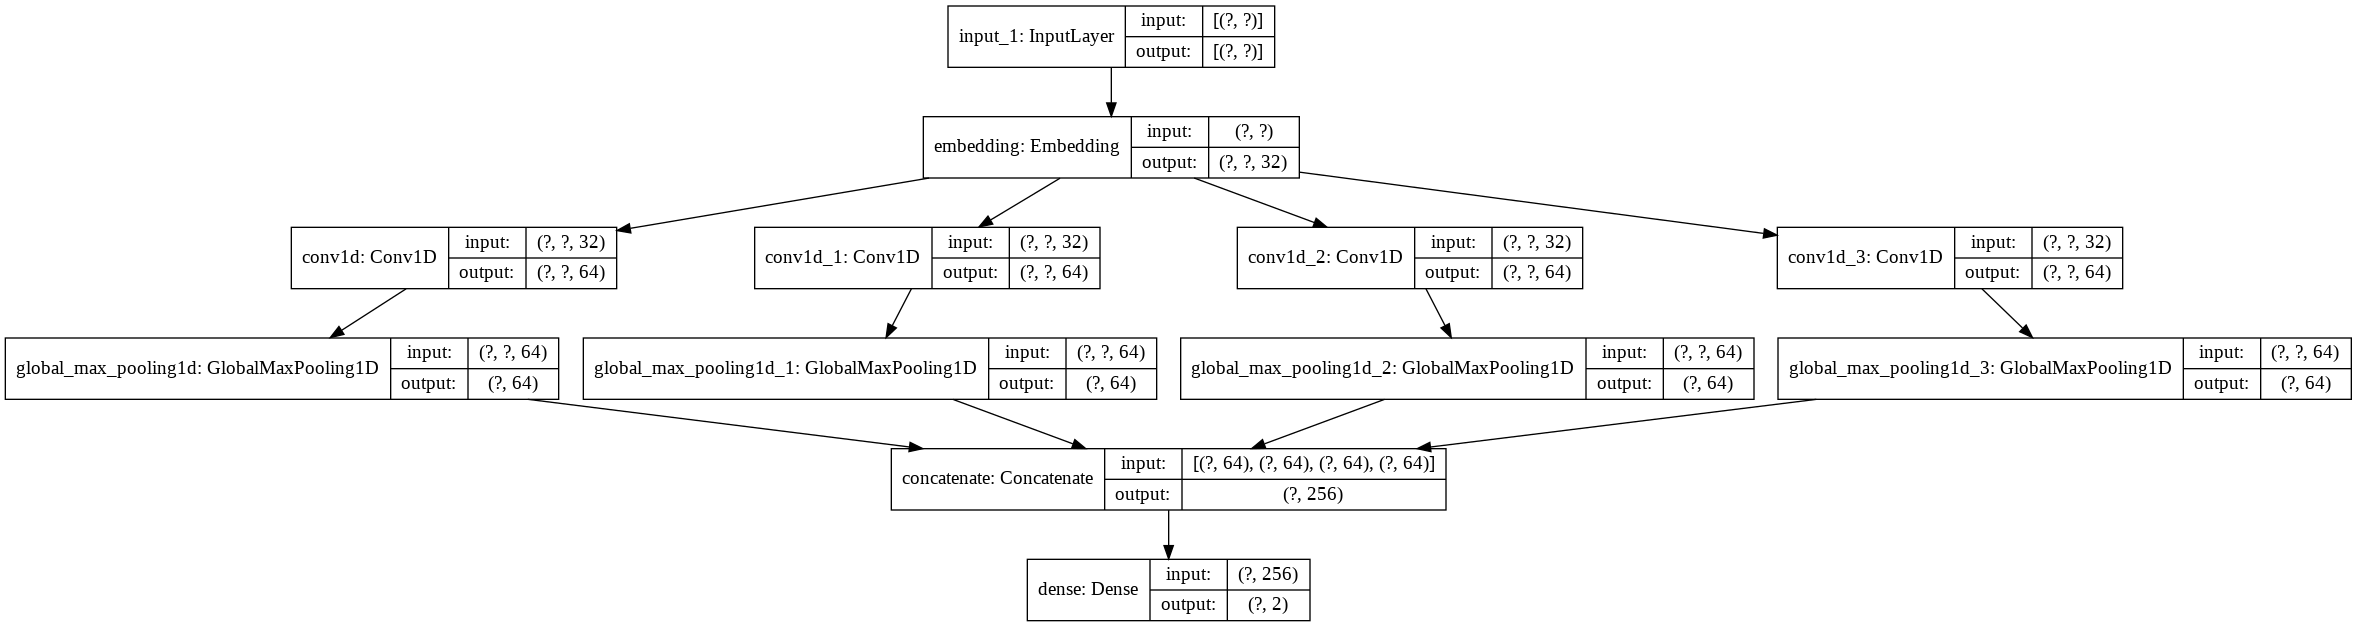

In [ ]:
# Char_CNN = tf.keras.Model(inputs=input_, outputs = labels)
# tf.keras.utils.plot_model(
#     Char_CNN, to_file='model.png', show_shapes=True)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense

tf.keras.backend.clear_session() 

vocab_size = text_encoder.vocab_size # 단어사전 개수 
embedding_dim = 32 # 임베딩 차원
cnn_filters = [3,4,5,6]
num_feature_map = 64


 
""" Character embedding 적용 """
## [★CODE 1★] Input Layer 정의하기 (Hint: tf.keras.layers.Input)
input_ = tf.keras.layers.Input(shape=(None,))
 
## [★CODE 2★] Input Layer에 Embedding Layer 연결하기
x =  Embedding(vocab_size, embedding_dim, mask_zero = True)(input_)
print("shape after embedding:", x.shape, "\n")
 
""" CNN filter 적용하기 """
## [★CODE 3★] 임베딩된 벡터에 CNN 필터 [3,4,5,6]을 각각 적용하고 MaxPooling을 적용하기
result_cnns = []
for i, kernel in enumerate(cnn_filters):
  print("Apply CNN filter {}".format(kernel))
  temp = Conv1D(filters = num_feature_map,
                    kernel_size = kernel, activation='relu')(x)
  print(".. shape after Convolution:", temp.shape)
  temp = GlobalMaxPooling1D()(temp)
  print(".. shape after Max Pooling:", temp.shape)
  result_cnns.append(temp)
 
## [★CODE 4★] 만들어진 feature map들을 concatenate하기
## Quiz)) 이 결과나오는 차원 수는? -> 4(필터종류) x 64(필터개수) = 256차원
x = tf.keras.layers.concatenate(result_cnns, axis=-1)
print("\nshape after concat   :", x.shape)
 
""" 긍정/부정 분류하는 FCN 연결하기 """
## [★CODE 5★] Dense layer를 이용해 긍정/부정 카테고리에 해당하는 점수 만들기
labels = Dense(2, activation="softmax")(x)

shape after embedding: (None, None, 32) 

Apply CNN filter 3
.. shape after Convolution: (None, None, 64)
.. shape after Max Pooling: (None, 64)
Apply CNN filter 4
.. shape after Convolution: (None, None, 64)
.. shape after Max Pooling: (None, 64)
Apply CNN filter 5
.. shape after Convolution: (None, None, 64)
.. shape after Max Pooling: (None, 64)
Apply CNN filter 6
.. shape after Convolution: (None, None, 64)
.. shape after Max Pooling: (None, 64)

shape after concat   : (None, 256)



모델 구조를 선언한 후    
tf.keras.utils.plot_model( model , to_file='model.png', show_shapes=True)    
함수를 이용해 예시로 주어진 모델과 구조가 같은지 확인해보세요.

<font color="red">MISSION :   
tf.keras.Model을 사용해서 input layer부터 final output까지 연결하기   
</font>  

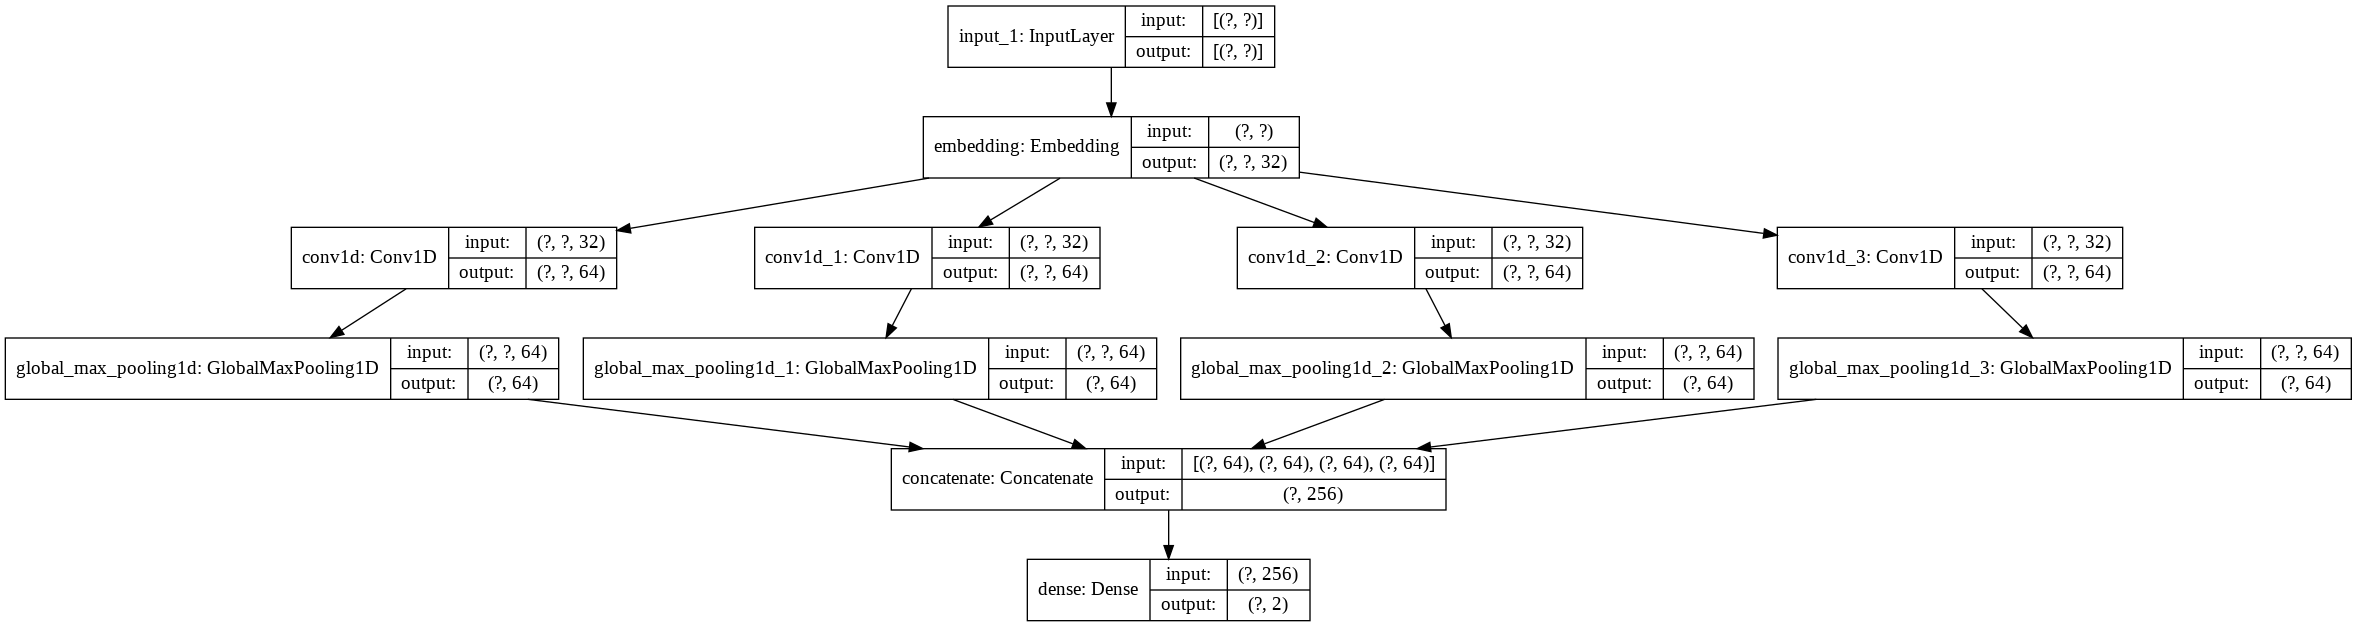

In [15]:
""" Your Code Here """

Char_CNN = tf.keras.Model(inputs=input_, outputs = labels)
tf.keras.utils.plot_model( Char_CNN , to_file='model.png', show_shapes=True)


# #4. 모델 훈련하기

#### 4-1) <b>model.compile()</b>을 통해 loss, optimizer 지정
<font color="red">MISSION : 적절한 loss와 optimizer를 지정하고, metric으로 "accuracy"를 측정하도록 모델을 컴파일하세요
</font>

In [16]:
""" Your Code Here """
Char_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#### 4-2) model.fit()을 통해 모델 훈련

<font color="red">MISSION : EarlyStopping Callback을 정의하고, 모델을 학습시켜보세요. 학습 로그는 history라는 이름으로 저장하세요.</font>
- epochs = 5
- batch_size = 100


In [17]:
## [★CODE 1★] Early Stopping Callback 정의하기
callback = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=1)
 
## [★CODE 2★] 모델 학습하기
num_epochs = 5
history = Char_CNN.fit(train_ids, train_labels,
                       epochs=num_epochs, batch_size=100,
                    validation_data=(val_ids, val_labels), callbacks=[callback])

Epoch 1/5
500/500 [==============================] - 4s 9ms/step - loss: 0.4785 - accuracy: 0.7656 - val_loss: 0.4062 - val_accuracy: 0.8141
Epoch 2/5
500/500 [==============================] - 3s 6ms/step - loss: 0.3744 - accuracy: 0.8354 - val_loss: 0.3812 - val_accuracy: 0.8261
Epoch 3/5
500/500 [==============================] - 3s 6ms/step - loss: 0.3287 - accuracy: 0.8589 - val_loss: 0.3693 - val_accuracy: 0.8346
Epoch 4/5
500/500 [==============================] - 3s 6ms/step - loss: 0.2891 - accuracy: 0.8805 - val_loss: 0.3685 - val_accuracy: 0.8387
Epoch 5/5
500/500 [==============================] - 3s 6ms/step - loss: 0.2546 - accuracy: 0.8979 - val_loss: 0.3765 - val_accuracy: 0.8367


👉 CNN을 사용한 모델은 한 epoch가 4초만에 휘리릭 학습되는 것을 볼 수 있습니다!    
👉 Character 임베딩을 했기 때문에 파라미터 개수가 적을 뿐만 아니라 CNN이 아주 빠른 모델이기 때문입니다.   
👉 Validation 정확도 역시 약 83~84%로, RNN 계열의 모델보다도 높게 나왔습니다. 


#### 4-3) 훈련 결과 진단하기

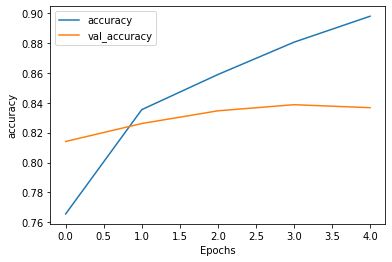

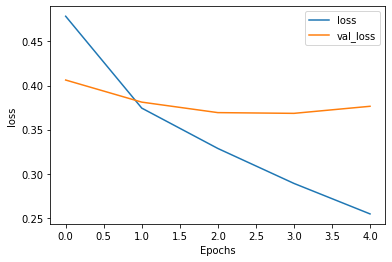

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

<font color="red">MISSION : Model.evaluate 함수를 통해 테스트 데이터에서의 정확도를 평가해보세요</font>

In [19]:
""" Your Code Here """
Char_CNN.evaluate(test_ids, test_labels)


313/313 [==============================] - 1s 2ms/step - loss: 0.3744 - accuracy: 0.8390


[0.37444818019866943, 0.8389999866485596]

# #5. Inference 실행하기

In [20]:
""" 훈련된 모델로 다시 예측해보기 """

def inference(mymodel, sentence, cnn_filters):
  # 1. tokenizer로 문장 파싱
  parsed_sent = tokenize(sentence)

  # 2. vocab_dict를 이용해 인덱스로 변환
  input_id = text_encoder.convert_tokens_to_ids(parsed_sent)

  input_id = [input_id]
  score = mymodel.predict(input_id) 

  print("** INPUT:", sentence)
  print("   -> 긍정: {:.2f} / 부정: {:.2f}".format(score[0][0],score[0][1]))

In [21]:
## Char_CNN은 제가 만든 모델 이름입니다.
## 여러분께서 만드신 모델 이름으로 바꿔서 추론을 진행해보세요!

inference(Char_CNN, "오프닝은 진짜 거지같다 생각했는데 끝으로 갈수록 손에 땀을 쥐며 봤네요", cnn_filters)

** INPUT: 오프닝은 진짜 거지같다 생각했는데 끝으로 갈수록 손에 땀을 쥐며 봤네요
   -> 긍정: 0.79 / 부정: 0.21


In [22]:
inference(Char_CNN, "ㅋ...", cnn_filters)

ValueError: ignored

👉 "ㅋ..."라는 문장에 대해서는 inference 코드에서 에러 메시지가 출력되었습니다.    
👉 에러 로그를 보면, Computed output size would be negative: -1 [input_size: 4, effective_filter_size: 6, stride: 1] 라고 나오는데요   

👉 우리 모델은 CNN filter로 [3,4,5,6]에 해당하는 커널 사이즈를 사용하고 있습니다.   
그런데, 입력된 문장은 길이가 4개밖에 되지 않습니다.   
이로 인해 Convolution과 MaxPooling을 하는 과정에서 차원 계산 에러가 발생하는 것입니다.  

👉 이러한 에러를 방지하기 위해    
"필터로 사용한 커널 크기의 최대 값보다는 문장 길이가 길어지도록 패딩하는 코드를 추가하여 inference 함수를 다시 정의하겠습니다. 

In [23]:
""" 훈련된 모델로 다시 예측해보기 """

def inference(mymodel, sentence, cnn_filters):
  # 1. tokenizer로 문장 파싱
  parsed_sent = tokenize(sentence)

  # 2. vocab_dict를 이용해 인덱스로 변환
  input_id = text_encoder.convert_tokens_to_ids(parsed_sent)

  # 3. 최대 필터 크기보다는 길게 만들기
  MIN_SEQ_LEN = max(cnn_filters)
  while len(input_id) < MIN_SEQ_LEN:
    input_id.append(0)
  input_id = [input_id]
  score = mymodel.predict(input_id) 

  print("** INPUT:", sentence)
  print("   -> 긍정: {:.2f} / 부정: {:.2f}".format(score[0][0],score[0][1]))

In [24]:
inference(Char_CNN, "ㅋ...", cnn_filters)

** INPUT: ㅋ...
   -> 긍정: 0.41 / 부정: 0.59
